In [2]:
pip install transformers datasets torch scikit-learn matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

#Importing the libraryes


In [1]:
import torch
from transformers import DistilBertTokenizer,DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Load the IMDB dataset

In [2]:
dataset = load_dataset("imdb")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [3]:

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Smaller subset for quick training

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(500))

# Smaller subset for quick evaluation

small_test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

# Load the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



# Define evaluation metrics

In [4]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert logits to tensor
    logits = torch.tensor(logits)

    # Get predicted labels
    predictions = logits.argmax(dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


# Define training arguments for fine-tuning

In [5]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    fp16=True,  # Enable mixed precision
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



# Initialize the Trainer for fine-tuning

In [6]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    compute_metrics=compute_metrics,
)

# Evaluate the model before fine-tuning

In [7]:
before_finetune_result = trainer.evaluate()
print(f"Before Fine-Tuning: {before_finetune_result}")


Before Fine-Tuning: {'eval_loss': 0.6956116557121277, 'eval_accuracy': 0.47, 'eval_f1': 0.624113475177305, 'eval_precision': 0.46808510638297873, 'eval_recall': 0.9361702127659575, 'eval_runtime': 119.6328, 'eval_samples_per_second': 0.836, 'eval_steps_per_second': 0.059}



# Fine-tune the model

In [8]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.652849,0.750000,0.742268,0.720000,0.765957


TrainOutput(global_step=32, training_loss=0.673876941204071, metrics={'train_runtime': 1927.3921, 'train_samples_per_second': 0.259, 'train_steps_per_second': 0.017, 'total_flos': 66233699328000.0, 'train_loss': 0.673876941204071, 'epoch': 1.0})

# Evaluate the model after fine-tuning

In [9]:
after_finetune_result = trainer.evaluate()
print(f"After Fine-Tuning: {after_finetune_result}")


After Fine-Tuning: {'eval_loss': 0.6528486013412476, 'eval_accuracy': 0.75, 'eval_f1': 0.7422680412371133, 'eval_precision': 0.72, 'eval_recall': 0.7659574468085106, 'eval_runtime': 97.8563, 'eval_samples_per_second': 1.022, 'eval_steps_per_second': 0.072, 'epoch': 1.0}


# Plotting the comparison

In [10]:
before_accuracy = before_finetune_result['eval_accuracy']
after_accuracy = after_finetune_result['eval_accuracy']

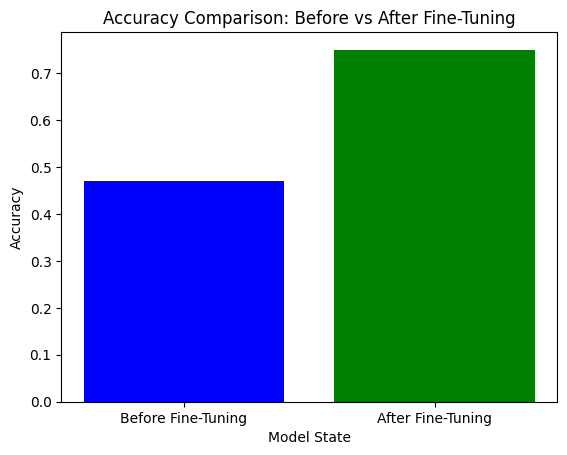

In [11]:
plt.bar(["Before Fine-Tuning", "After Fine-Tuning"], [before_accuracy, after_accuracy], color=['blue', 'green'])
plt.xlabel("Model State")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Before vs After Fine-Tuning")
plt.show()